1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy import fftpack as fp

In [2]:
mu = 6.3
x0 = 15
sigma = np.sqrt(mu)

Z = (x0 - mu)/sigma
if Z >= 3:
    print(x0, "hurricanes is  signficantly different from the historic average")
else:
    print(x0, "hurricanes is  no signficantly different from the historic average")

15 hurricanes is  signficantly different from the historic average


2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

p-value: 0.7119807631837114 alpha: 0.05
the change in blood pressure was not statistically significant


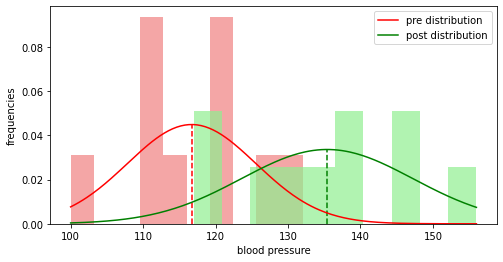

In [3]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
alpha = 0.05

n = len(pre)
mean_pre, sigma_pre = np.mean(pre), np.std(pre)
mean_post, sigma_post  = np.mean(post), np.std(post)
sigma = (sigma_pre**2 + sigma_post**2)/2
T = (mean_pre - mean_post)/(sigma * np.sqrt(2/n))
pvalue = stats.t.cdf(T, n - 1) + (1. - stats.t.cdf(-T, n - 1))
print("p-value:", pvalue, "alpha:", alpha)
if pvalue < alpha:
    print("the change in blood pressure was statistically significant")
else:
    print("the change in blood pressure was not statistically significant")
# plotting the two sample's gaussians
all = np.reshape([pre, post], (20,))
x = np.linspace(all.min(), all.max(), 200)
plt.figure(figsize=(8,4))
plt.hist(pre, density=True, color='lightcoral', alpha=0.7)
plt.hist(post, density=True, color='lightgreen', alpha=0.7)
g_pre, g_post = stats.norm.pdf(x, loc=mean_pre, scale=sigma_pre), stats.norm.pdf(x, loc=mean_post, scale=sigma_post)
plt.plot(x, g_pre, 'r', label='pre distribution')
plt.plot(x, g_post, 'g', label='post distribution')
plt.vlines(mean_pre, 0, g_pre.max(), colors='red', linestyles='dashed')
plt.vlines(mean_post, 0, g_post.max(), colors='green', linestyles='dashed')
plt.xlabel("blood pressure")
plt.ylabel("frequencies")
plt.legend()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

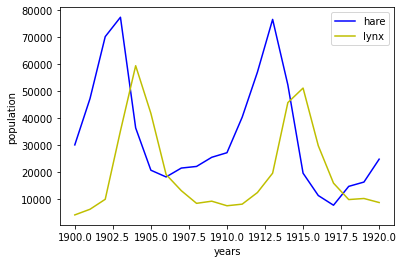

In [4]:
filename = r'C:\Users\Marco\Desktop\Lab Cartella\populations.txt'
data = np.loadtxt(filename)
df = pd.DataFrame()
year, hare, lynx, carrot = data[:,0], data[:,1], data[:,2], data[:,3]
plt.plot(year, hare, 'b', label='hare')
plt.plot(year, lynx, 'y', label='lynx')
plt.xlabel("years")
plt.ylabel("population")
plt.legend()

Peak of hares: 0.09523809523809523
Peak of lynx: 0.09523809523809523
Period of hares: 10.5 years
Period of lynx: 10.5 years


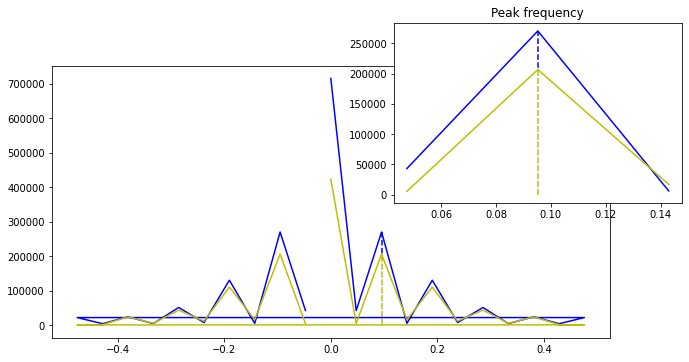

In [5]:
hare_pow, lynx_pow = np.abs(fp.fft(hare)), np.abs(fp.fft(lynx))
sample_freq = fp.fftfreq(hare.size)
pos_mask = np.where(sample_freq > 0)
freq_pos = sample_freq[pos_mask]
hare_pow_pos, lynx_pow_pos = hare_pow[pos_mask], lynx_pow[pos_mask]
hare_peak, lynx_peak = freq_pos[hare_pow_pos.argmax()], freq_pos[lynx_pow_pos.argmax()]
plt.figure(figsize=(10,5))
plt.plot(sample_freq, hare_pow,  'b', label='hare FT')
plt.plot(sample_freq, lynx_pow, 'y', label='lynx FT')
plt.vlines(hare_peak, 0, hare_pow_pos.max(), colors='blue', linestyles='dashed', label='hare freq peak')
plt.vlines(lynx_peak, 0, lynx_pow_pos.max(), colors='yellow', linestyles='dashed', label='lynx freq peak')
# inner plot
axes = plt.axes([0.6, 0.5, 0.4, 0.5])
plt.title('Peak frequency')
plt.plot(freq_pos[hare_pow_pos.argmax()-1:hare_pow_pos.argmax()+2],
         hare_pow_pos[hare_pow_pos.argmax()-1:hare_pow_pos.argmax()+2],  'b', label='hare FT')
plt.plot(freq_pos[lynx_pow_pos.argmax()-1:lynx_pow_pos.argmax()+2],
         lynx_pow_pos[lynx_pow_pos.argmax()-1:lynx_pow_pos.argmax()+2],  'y', label='lynx FT')
plt.vlines(hare_peak, 0, hare_pow_pos.max(), colors='blue', linestyles='dashed', label='hare freq peak')
plt.vlines(lynx_peak, 0, lynx_pow_pos.max(), colors='yellow', linestyles='dashed', label='lynx freq peak')
print("Peak of hares:", hare_peak)
print("Peak of lynx:", lynx_peak)
print("Period of hares:", 1/hare_peak, "years")
print("Period of lynx:", 1/lynx_peak, "years")


Now we want to "remove the noise" fom the popolation curves using the inverse fourier trasform, obtaining the curves relative at the periods found. We know that each peak are equal, and so the periods, so we are going to write just one filter (that set to zero all the frequencies except the peak one)

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

Text(0.5, 1.0, 'Fourier Spectrum Filtered')

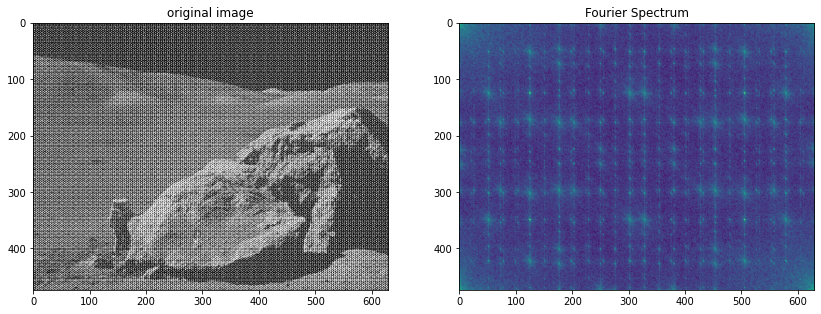

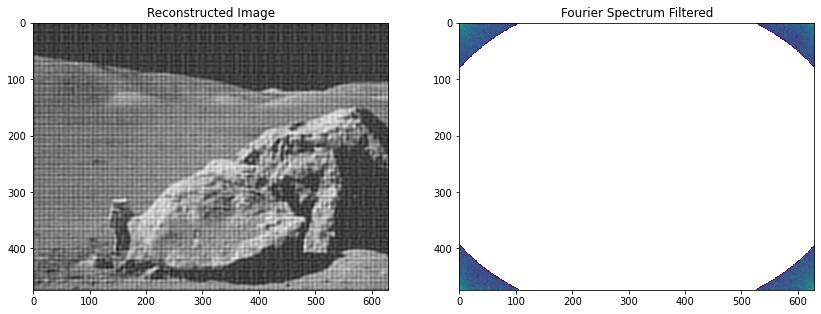

In [20]:
from matplotlib.colors import LogNorm
filename = r"C:\Users\Marco\Desktop\Lab Cartella\moonlanding.png"
image_read=plt.imread(filename)

fig, ax = plt.subplots(1, 2, figsize=(14,8))

ax[0].imshow(image_read, cmap='gray')
ax[0].set_title('original image')

fft_image = fp.fft2(image_read)
ax[1].imshow(np.abs(fft_image), norm=LogNorm(vmin=5))
ax[1].set_title('Fourier Spectrum')

shape = np.array(fft_image.shape)
R = int(shape.min())
center = np.array([np.around(int(shape[0])/2), np.around(int(shape[1])/2)])
s_a, s_b = center[0], center[1]
mask = []

for i in range(shape[0]):  #  elliptical filter (i found cooler use this filter than the regular squadred one)
    for j in range(shape[1]):
        a, b = i - center[0], j - center[1]
        d = np.sqrt((a/s_a)**2 + (b/s_b)**2)
        if d < 1.2 :
            mask.append(True)
        else:
            mask.append(False)
mask = np.reshape(np.array(mask), (shape[0], shape[1]))
fft_filt = fft_image.copy()
fft_filt[mask] = 0
image_filt = fp.ifft2(fft_filt).real

fig2, ax2 = plt.subplots(1, 2, figsize=(14,8))

ax2[0].imshow(image_filt, cmap='gray')
ax2[0].set_title('Reconstructed Image')

ax2[1].imshow(np.abs(fft_filt), norm=LogNorm(vmin=5))
ax2[1].set_title('Fourier Spectrum Filtered')
